# Implied Meridional MSE Transport with MERRA-2 Data

In this project I am going to use the MERRA-2 reanalysis dataset, produced by NASA GMAO, to diagnose the implied meridional moist static energy transport in the atmosphere in the annual mean and zonal mean. Moist static energy 

$$S = C_pT+gz+L_vq$$

is a property of air that sums the energy from the temperature of the air (thermal energy), the moisture content of that air (latent heat), and the gravitational potential energy (height) of the air. What I will be calculating is called "implied" transport because rather than calculating the MSE flux from the above quantities directly, I will be using net fluxes of energy into the atmospheric column at the top of the atmosphere (TOA) through shortwave and longwave radiation and at the surface through SW and LW radiation as well as sensible and latent heat fluxes from conduction and evaporation. Then, assuming "steady state" (i.e., the time derivative of the amount of energy contained in a particular atmospheric column is zero; or in other words, there is no net heating or cooling anywhere), any instantaneous net flux into the column means that that same amount of flux must be transported horizontally out of the column, and if I take the zonal mean as I will here, that transport must be meridional. 

![Hadley cell](https://groups.seas.harvard.edu/climate/eli/research/equable/images/Hadley%20Cell.png)

Image credit: [Mark Piana](https://groups.seas.harvard.edu/climate/eli/research/equable/hadley.html)

<img src="donohoe_2020.jpg" alt="drawing" width="500"/>

Image credit: [Donohoe et al. (2020)](https://journals.ametsoc.org/view/journals/clim/33/10/jcli-d-19-0797.1.xml)

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import fsspec
import hvplot.xarray
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

## Downloading Data

The files are stored in a GCP bucket [here](https://console.cloud.google.com/storage/browser/rces-data;tab=objects?prefix=&forceOnObjectsSortingFiltering=false). They were originally downloaded from [here](https://disc.gsfc.nasa.gov/datasets/M2TMNXINT_5.12.4/summary?keywords=M2TMNXINT).

In [3]:
# Let's load in the data from 1980 to 2019
fs = fsspec.filesystem('gcs', anon=True)
years = np.arange(1980,2020)
filepaths = [f'gs://rces-data/merra2_{year}.nc' for year in years]
data = [fs.open(fp, mode='rb', anon=True) for fp in filepaths]
ds = xr.open_mfdataset(data, engine='h5netcdf', chunks={})

In [4]:
ds

<xarray.Dataset>
Dimensions:   (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables:
    EVAP      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETTOA  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWGNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETSRF  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

## Explaining the Procedure

I have the variables I want here. Time goes from January 1980 to December 2019, as expected, and the size of each variable DataArray is 480 (months) by 361 (latitude) by 576 (longitude), as the [File Specification](https://gmao.gsfc.nasa.gov/pubs/docs/Bosilovich785.pdf) says it should be. 

Now I want to try getting the implied meridional MSE transport for each year.

I can either take the zonal mean of the relevant variables first, then combine them to get the zonal mean implied energy transport, or I can do the opposite, where I first compute the net energy flux into each grid column, and then I take the zonal mean to get the implied meridional energy transport. I'll go for the latter here.

How should I do this? Remember, I'm not actually calculating the MSE flux directly - I'm getting the _implied_ transport, so I'm not going to use the equation from the top of the notebook. Rather, I want to calculate for _each_ 0.625$^\circ$ x 0.5$^\circ$ grid cell the following: 

$$F_{net,\ tot} = F_{net,\ rad} + F_{net,\ sen} + F_{net,\ lat},$$

where 

$$F_{net,\ rad} = F^{net}_{LW,\ s} - F^{\uparrow}_{LW,\ TOA} + F^{net}_{SW,\ s} + F^{net}_{SW,\ TOA}\ \ (1),$$

$F_{net,\ sen}$ is the sensible heat flux (i.e., from conduction) from the ground to the air above, and 

$$F_{net,\ lat} = L_v * \text{EVAP}\ \ (2).$$

In words, (1) says that the net radiative flux into the column is equal to the net longwave flux into the column at the surface, minus the upwelling longwave flux at the top of the atmosphere (TOA), plus the net shortwave flux into the column at the surface, plus the net shortwave flux into the column at TOA. (2) says that the net latent heat flux into the column is simply equal to water's latent heat of vaporization times the mass of water evaporating into the column per unit time.

## Data Manipulation and Exploration

The first thing I'll do is combine the two rainfall variables (PRECCU represents "convective rainfall," while PRECLS represents "large-scale rainfall") to get a DataArray representing total rainfall. While this is not actually needed to diagnose the implied MSE transport, it will allow me to plot the rainfall near India, which I'll do later to make sure the data look right.

In [5]:
# Combine rainfall into a 'total rain' DataArray
ds['TOTRAIN'] = ds.PRECCU + ds.PRECLS
ds

<xarray.Dataset>
Dimensions:   (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables:
    EVAP      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETTOA  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWGNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETSRF  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    TOTRAIN   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

I'll also make a DataArray for precipitation minus evaporation, or "P minus E," which I'll use later to find the Hadley cell in the data.

In [273]:
# Fancy P minus E plot
ds['PMINUSE'] = ds.PRECCU + ds.PRECLS + ds.PRECSN - ds.EVAP
ds

<xarray.Dataset>
Dimensions:    (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables: (12/16)
    EVAP       (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    ...         ...
    FNETRAD    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETSEN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETLAT    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETTOTAL  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETZONAL  (time, lat) float32 dask.array<chunksize=(12, 361), meta=np.ndarray>
    PMINUSE    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

In [239]:
# Function to take care of the 12-panel plot making so I don't have to type out a whole bunch of code over and
# over again
def make_12panel(suptitle,dataarray,cbar_label,cmap=None,vmin=None,vmax=None,norm=None):
    """
    Important note: this function assumes that the first dimension for the DataArray you want to plot is the 
    time/monthly dimension. The place where it assumes this is in the "dataarray[i].plot()" call below. If 
    your data does not fit this, this function won't work properly.
    """
    fig, axs = plt.subplots(nrows=3,ncols=4,figsize=(20,12),sharex='col',sharey='row')
    month_strings = ['January','February','March','April','May','June','July','August','September','October',\
                 'November','December']
    plt.suptitle(suptitle,fontsize=22)
    for i, ax in enumerate(axs.flatten()):
        if i % 4 == 3: # Subplot is on the right side, so show colorbar label
            dataarray[i].plot(ax=ax,norm=norm,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label':cbar_label})
        else:
            dataarray[i].plot(ax=ax,norm=norm,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label':''})
        ax.set_title(month_strings[i])
        if i < 8: # Subplot is in top 2 rows, so don't show x-axis label
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Longitude (Deg. East)')
        if i % 4 == 0: # Subplot is on the left side, so show y-axis label
            ax.set_ylabel('Latitude (Deg. North)')
        else:
            ax.set_ylabel('')
    plt.show()

In [72]:
# First let's write a function to take a year of my choice and extract only variables from that year
# Actually I'm going to write this so that I can specify two years if I want to give an arbitrary range of time. 
# Then if I only want one year, I can just supply one year, but if I want (e.g.) 5 years, I can get that too
def get_year(dsda, year1, year2=None):
    # dsda should be either a Dataset (ds) or DataArray (da)
    if year2 is None:
        year2 = year1
    return dsda.sel(time=slice(f'{year1}-01-01',f'{year2}-12-31'))

# Now let me write a function to take the 40 years' worth of data and calculate the average for each month.
# Actually, I'll want to let myself specify any year range I want, so what I'll do is feed in a Dataset, and 
# if I want all 40 years, I'll just feed in ds. If I want a smaller range of years, I'll use get_year() above
# To put it succinctly, this function calculates a monthly climatology for any variable(s) you want
def get_monthly(ds,var=None):
    # If you want a specific variable only (this would probably help to make the function faster, as long as you
    # only care about that one variable), then you can specify the string name of that variable in the keyword var
    # and I'll replace ds with just the DataArray representing var
    if var is not None:
        ds = ds[var]
    # Might want to use groupby here - group by month of year, then take the mean of each group
    gb = ds.groupby('time.month') # Remember, this could be a DataArray if var != None; otherwise Dataset
    ds_mms = gb.mean(dim='time') # 'mm' for 'monthly mean'
    # At this point we have monthly means (averaged over however many years are in the dataset) for either
    # 1) all the variables (if var=None) or 2) one particular variable var (if var is not None). That's 
    # really all I want here, so let's return it
    return ds_mms
    
# I might also want a function that can compute the annual mean (weighted average based on length of month) for
# an arbitrary length of years. For example, this is what I want to do with my net flux measurements. I'd like
# to be on the more general side with how I write this so it's more widely applicable - I think this function
# should be able to handle both single-year (including monthly mean averages of multiple years such as the output
# of get_monthly(), above) and multi-year inputs here. Note that for multi-year inputs, the idea is that I would
# feed in, say, 20 years' worth of raw monthly data, then I'd get the annual mean for each year so I end up with
# just 20 numbers (per variable, per grid cell) at the end
def get_annual_mean(ds,var=None):
    if var is not None: # Again, allow the freedom to get the annual mean for only 1 variable instead of whole ds
        ds = ds[var]
    gb = ds.groupby('time.year') # TODO: This might not work if ds is already a mm average of several years
    # Weight by length of each month (February shouldn't count as much as July)
    ds_ams = gb.map(weighted_monthly_average) # 'am' for 'annual mean'
    return ds_ams

# This is a helper function for get_annual_mean() that will take care of weighting by month length
def weighted_monthly_average(dsda):
    # Since we're feeding into gb.map() a groupby object which is already grouped by year, this function should
    # only have to deal with one year's worth of data at a time
    weights = dsda.time.dt.days_in_month
    weights = weights / weights.sum() # Make sure the weights sum to 1
    return dsda.weighted(weights).mean('time')

Here I'll get the monthly climatology over the 40 years in ds_mms, and I'll get the 40 annual means (averaged over month of year) in ds_ams. These include all the variables I have so far.

In [274]:
ds_mms = get_monthly(ds)
ds_ams = get_annual_mean(ds)

In [275]:
ds_mms

<xarray.Dataset>
Dimensions:    (month: 12, lat: 361, lon: 576)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/16)
    EVAP       (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    PRECLS     (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    LWTNET     (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    PRECCU     (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    PRECSN     (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    HFLUX      (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    ...         ...
    FNETRAD    (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETSEN    (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETLAT    (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETTOTAL  (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETZONAL  (month, lat) float32 dask.array<chunksize=(1, 361), meta=np.ndarray>
    PMINUSE    (month, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>

In [276]:
ds_ams

<xarray.Dataset>
Dimensions:    (lat: 361, lon: 576, year: 40)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * year       (year) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
Data variables: (12/16)
    EVAP       (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    PRECLS     (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    LWTNET     (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    PRECCU     (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    PRECSN     (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    HFLUX      (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    ...         ...
    FNETRAD    (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETSEN    (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETLAT    (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETTOTAL  (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    FNETZONAL  (year, lat) float64 dask.array<chunksize=(1, 361), meta=np.ndarray>
    PMINUSE    (year, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>

Before I get into calculating the implied MSE flux, there are some interesting things we can look at using the precipitation and evaporation data from MERRA-2. Here let me begin by plotting the monthly climatology of global rainfall.

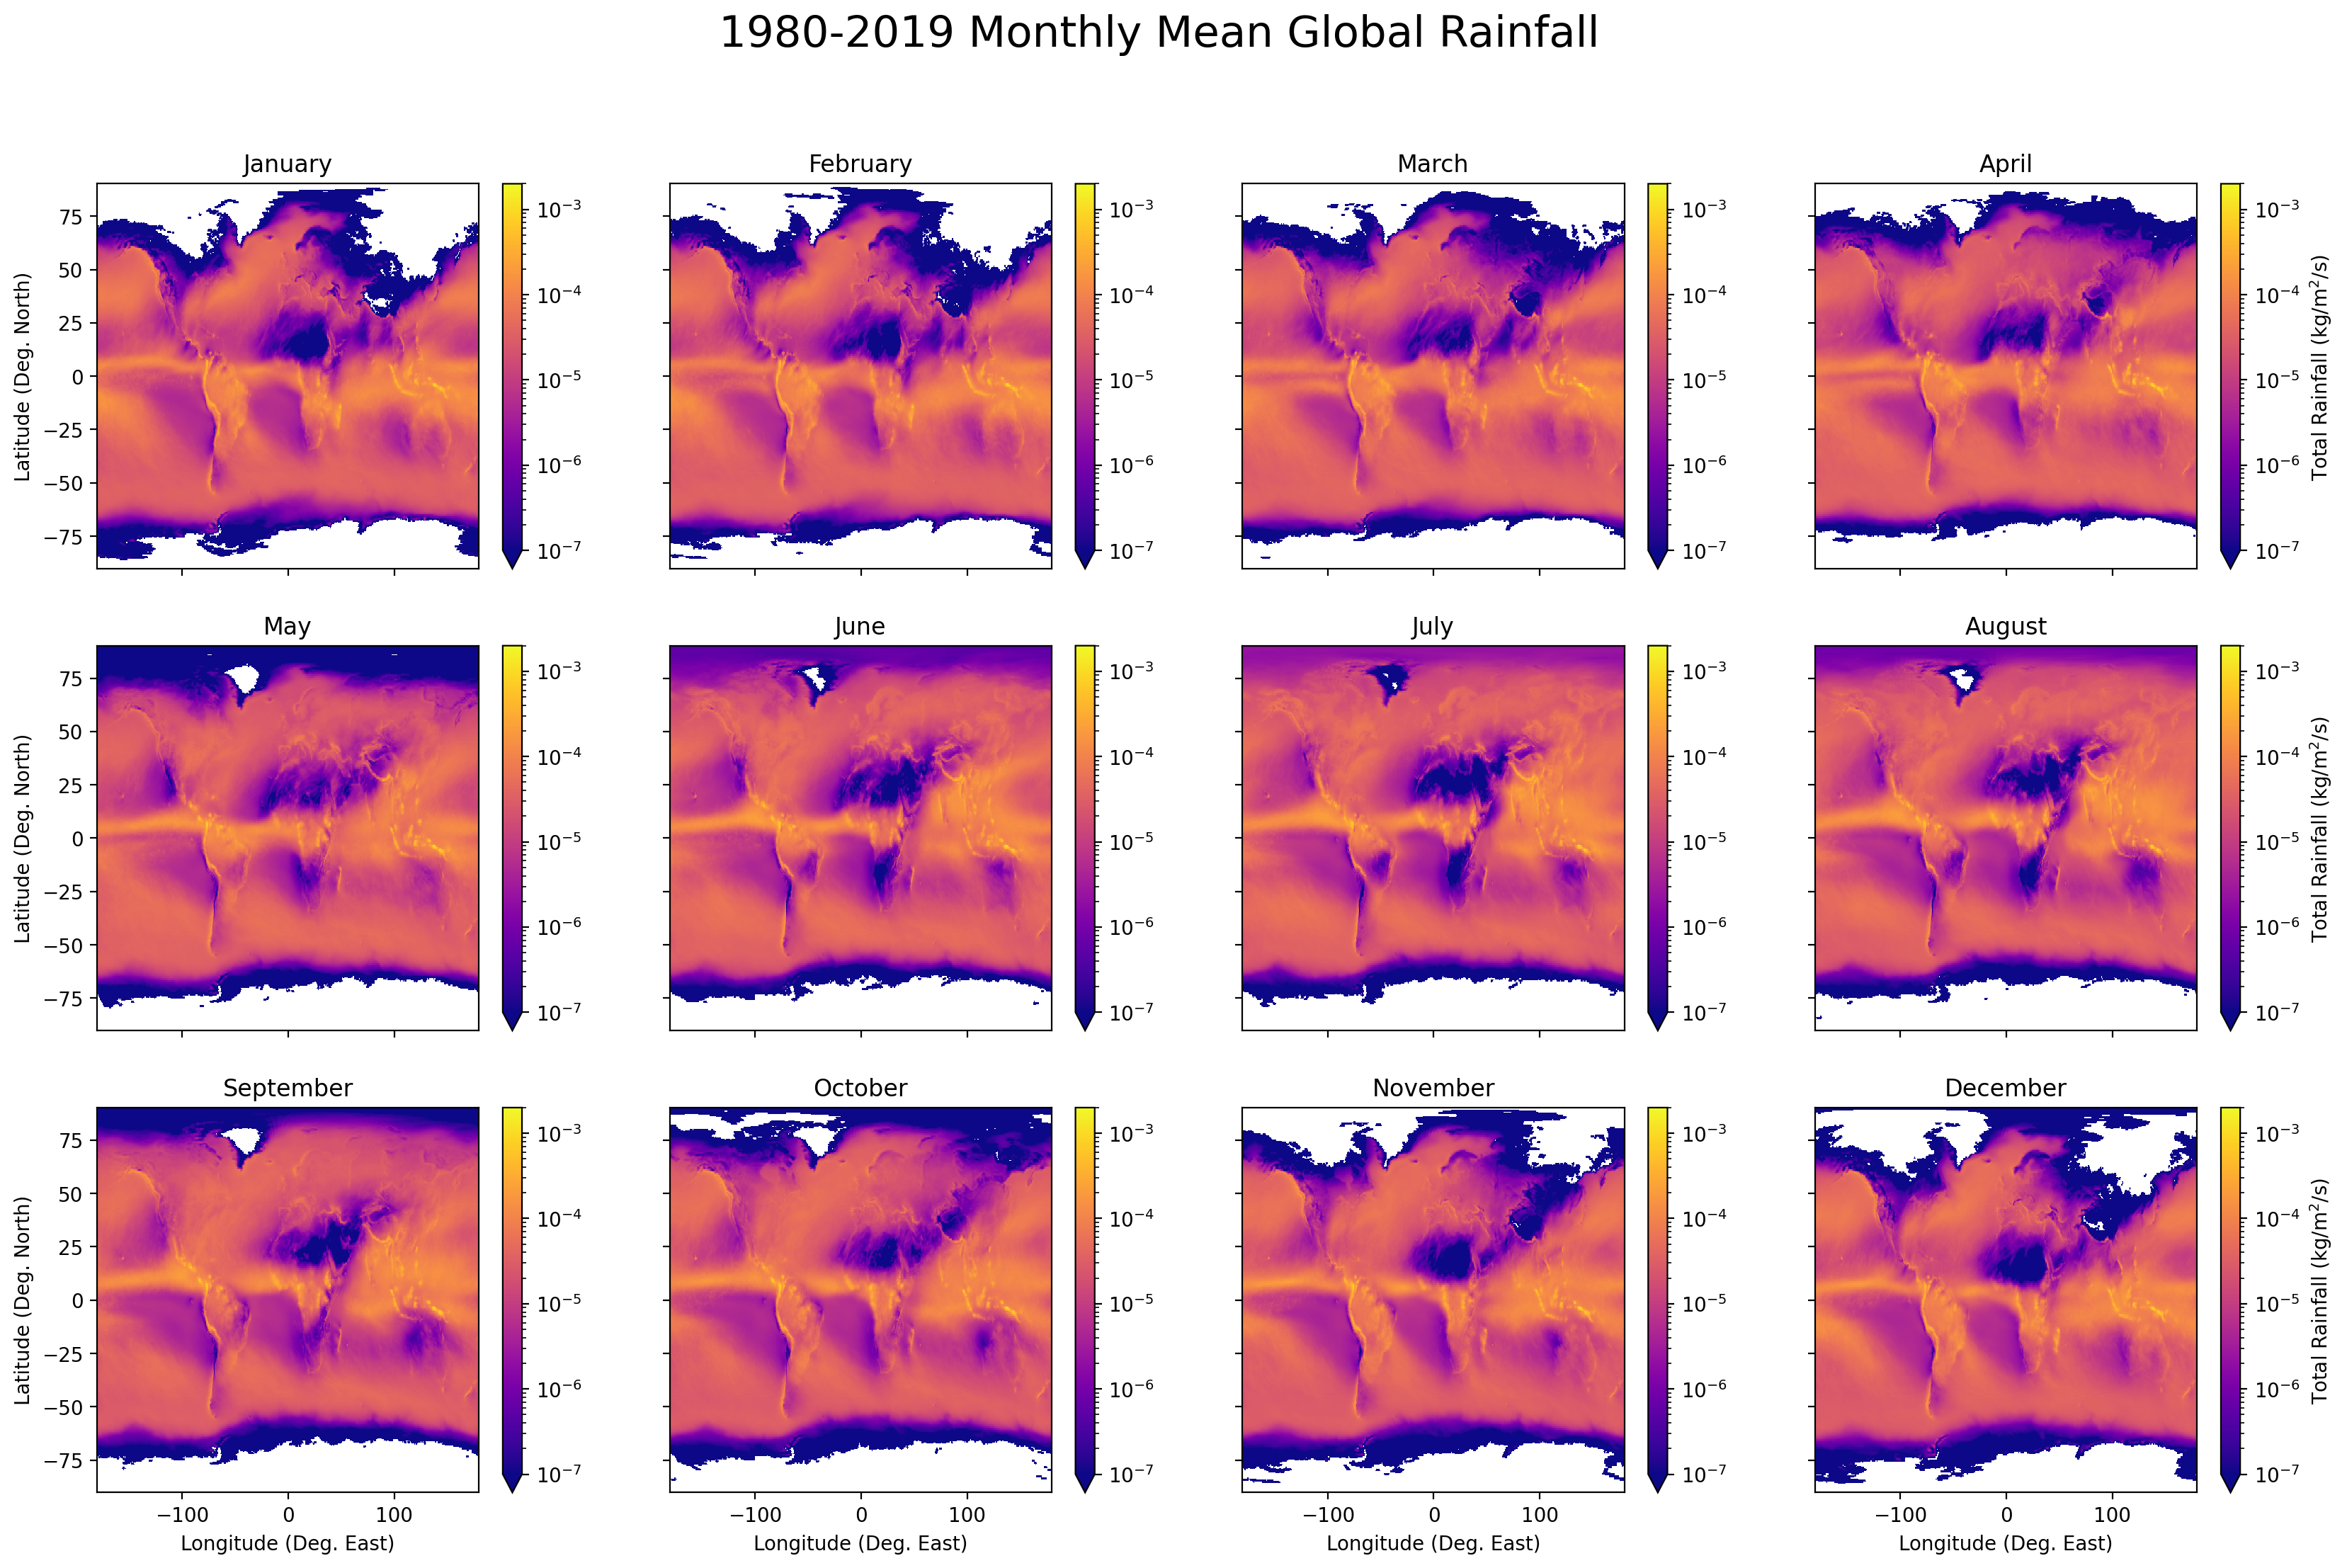

In [246]:
make_12panel('1980-2019 Monthly Mean Global Rainfall',ds_mms.TOTRAIN,r'Total Rainfall (kg/m$^2$/s)',cmap='plasma',norm=mpl.colors.LogNorm(vmin=1e-7, vmax=0.002))

At a glance, this seems to make sense - we can see the intertropical convergence zone (ITCZ) as a band of heavy rain near the equator, and the tropics in general have more rain than the poles. Let's dig a little deeper.

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


Text(0.5, 1.0, 'Anomaly of Global Mean Monthly Rainfall, 1980-2019')

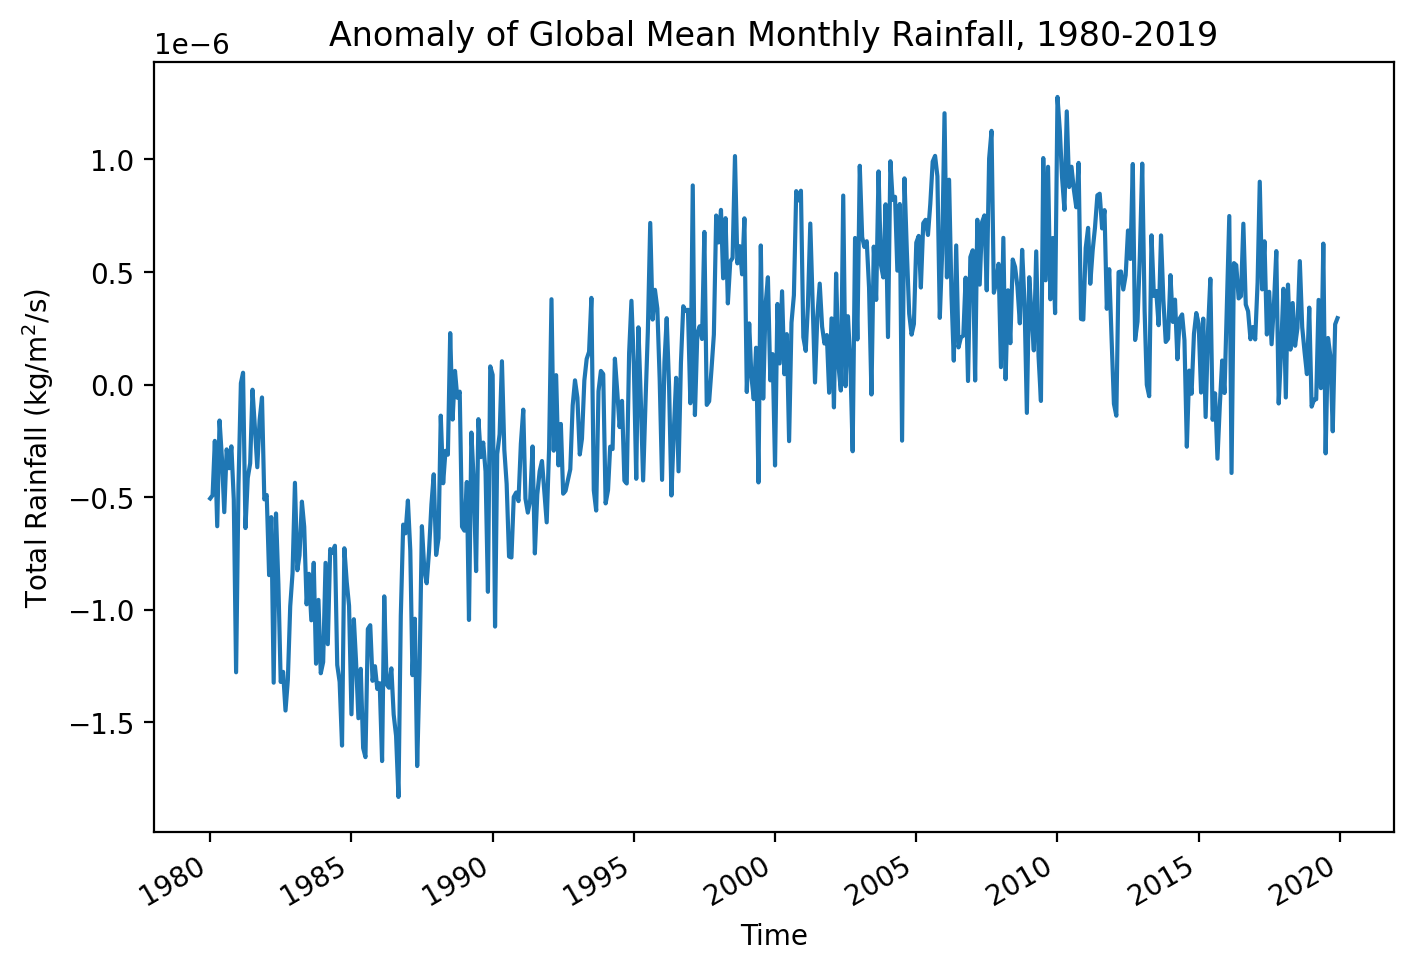

In [315]:
# Calculate anomaly of global rainfall over time
gb = ds.TOTRAIN.mean(dim=['lat','lon']).groupby('time.month')
anomaly = gb - gb.mean()
anomaly.plot(figsize=(8,5))
plt.xlabel('Time')
plt.ylabel(r'Total Rainfall (kg/m$^2$/s)')
plt.title('Anomaly of Global Mean Monthly Rainfall, 1980-2019')

The above plot is an anomaly plot, and it's not flat over time - it's at least slightly increasing. Therefore it seems that, in a globally averaged sense, the amount of rain has been increasing over the last 40 years. This makes sense considering the anthropogenic increase in globally averaged temperature (and therefore humidity) during this time.

Let's now look closer at a particular region.

/tmp/ipykernel_1436/1780331451.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.4, 0.98, 'Indian Seasonal Rainfall, 1980-2019')

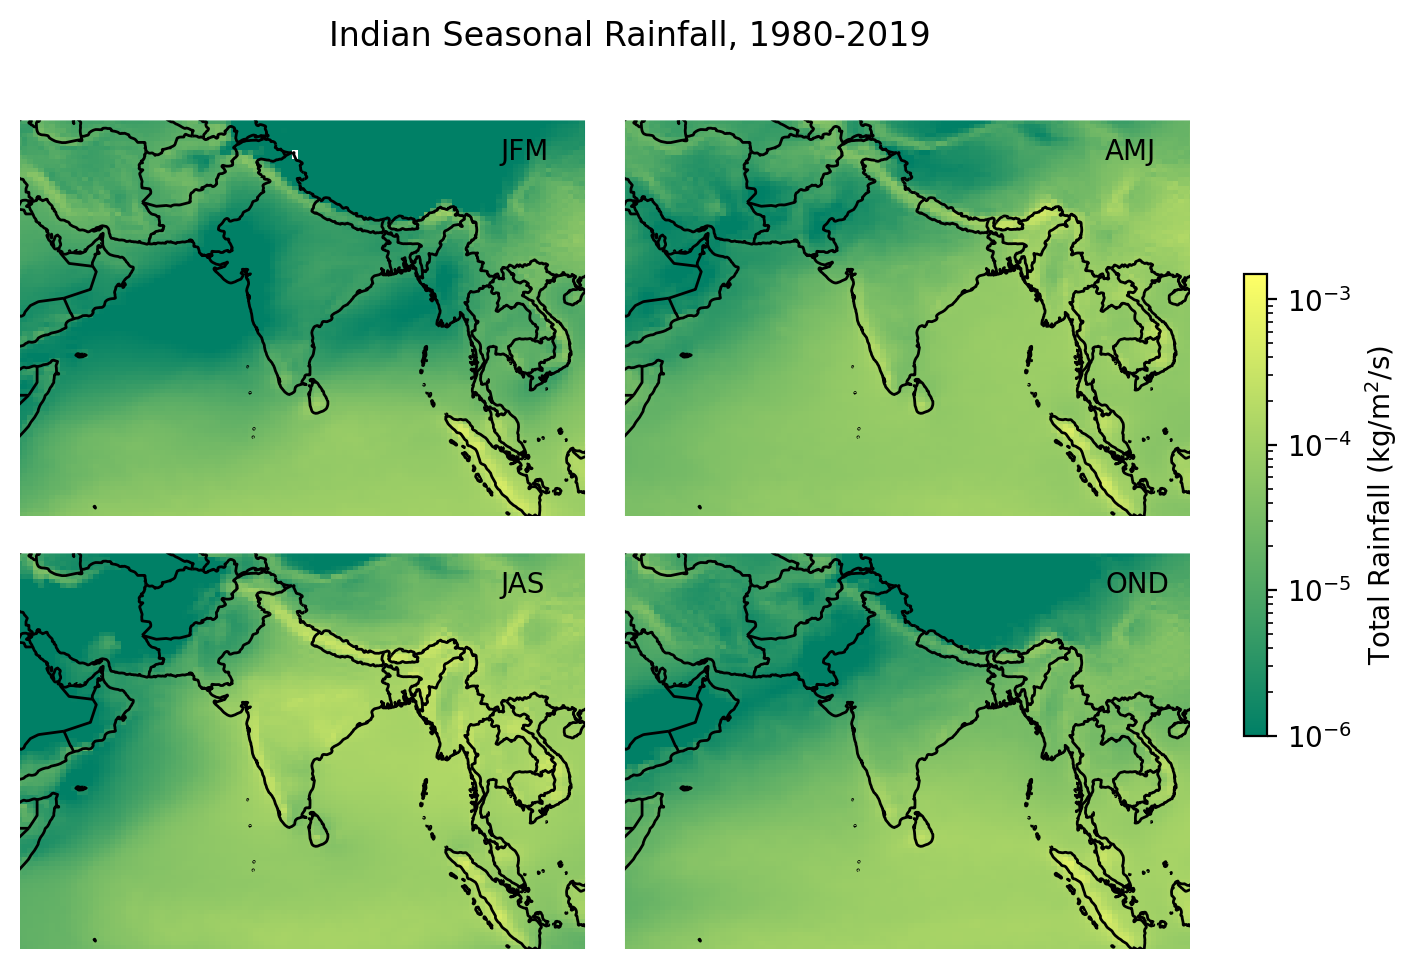

In [272]:
fig, axs = plt.subplots(figsize=(8,5),nrows=2,ncols=2,subplot_kw={'projection': ccrs.PlateCarree()})
for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent((47,111,-5,35))
    ax.add_feature(cfeature.BORDERS)
    ax.set_axis_off()
im1 = ds_mms.TOTRAIN.sel(month=slice(1,3)).mean('month').plot(ax=axs[0,0],norm=mpl.colors.LogNorm(vmin=1e-6, vmax=0.0015),cmap='summer',add_colorbar=False) # JFM
im2 = ds_mms.TOTRAIN.sel(month=slice(4,6)).mean('month').plot(ax=axs[0,1],norm=mpl.colors.LogNorm(vmin=1e-6, vmax=0.0015),cmap='summer',add_colorbar=False) # AMJ
im3 = ds_mms.TOTRAIN.sel(month=slice(7,9)).mean('month').plot(ax=axs[1,0],norm=mpl.colors.LogNorm(vmin=1e-6, vmax=0.0015),cmap='summer',add_colorbar=False) # JAS
im4 = ds_mms.TOTRAIN.sel(month=slice(10,12)).mean('month').plot(ax=axs[1,1],norm=mpl.colors.LogNorm(vmin=1e-6, vmax=0.0015),cmap='summer',add_colorbar=False) # OND
axs[0,0].annotate('JFM',xy=(0.85,0.9),xycoords='axes fraction')
axs[0,1].annotate('AMJ',xy=(0.85,0.9),xycoords='axes fraction')
axs[1,0].annotate('JAS',xy=(0.85,0.9),xycoords='axes fraction')
axs[1,1].annotate('OND',xy=(0.85,0.9),xycoords='axes fraction')
cbar = fig.colorbar(im4,ax=axs.ravel().tolist(),shrink=0.6,label=r'Total Rainfall (kg/m$^2$/s)')
plt.tight_layout()
plt.subplots_adjust(right=0.75,top=0.9)
plt.suptitle('Indian Seasonal Rainfall, 1980-2019',x=0.4)

In order to validate the rainfall data in a particular region, let's consider the Indian monsoon. India is located at about 20 deg. N, 79 deg. E. NOAA [says](https://www.cpc.ncep.noaa.gov/products/assessments/assess_96/india.html) that the Indian monsoon season is approximately June - September. Here I am plotting the seasonal mean of rainfall in the region around India. Looking at the plots above, it does look like the rainfall levels in India are going up considerably during July-August-September (JAS), so that's another piece of evidence that this data is correct. Cool!

Let's now look at something directly relevant to the MSE transport - a global plot of precipitation minus evaporation, which will hopefully let us see the Hadley cell, the primary engine of the meridional energy transport in the tropics.

In [281]:
# Load this DataArray into memory to save time plotting
ds_ams.PMINUSE.load()

<xarray.DataArray 'PMINUSE' (year: 40, lat: 361, lon: 576)>
array([[[1.39957077e-06, 1.39957077e-06, 1.39957077e-06, ...,
         1.39957077e-06, 1.39957077e-06, 1.39957077e-06],
        [1.51008531e-06, 1.50198426e-06, 1.50198426e-06, ...,
         1.52358725e-06, 1.52358725e-06, 1.52358725e-06],
        [1.65587076e-06, 1.65587076e-06, 1.65587076e-06, ...,
         1.65587076e-06, 1.65587076e-06, 1.65587076e-06],
        ...,
        [6.25479978e-06, 6.25479978e-06, 6.25479978e-06, ...,
         6.25479978e-06, 6.25479978e-06, 6.25479978e-06],
        [6.16495867e-06, 6.16542011e-06, 6.16542011e-06, ...,
         6.16394385e-06, 6.16394385e-06, 6.16394385e-06],
        [6.17241925e-06, 6.17241925e-06, 6.17241925e-06, ...,
         6.17241925e-06, 6.17241925e-06, 6.17241925e-06]],

       [[1.92177100e-06, 1.92177100e-06, 1.92177100e-06, ...,
         1.92177100e-06, 1.92177100e-06, 1.92177100e-06],
        [1.91630960e-06, 1.91670995e-06, 1.91670995e-06, ...,
         1.91564248e-06, 1.91564248e-06, 1.91564248e-06],
        [1.86567993e-06, 1.86567993e-06, 1.86567993e-06, ...,
         1.86567993e-06, 1.86567993e-06, 1.86567993e-06],
...
        [7.12203363e-06, 7.12203363e-06, 7.12203363e-06, ...,
         7.12203363e-06, 7.12203363e-06, 7.12203363e-06],
        [6.83550596e-06, 6.82231336e-06, 6.82231336e-06, ...,
         6.86453009e-06, 6.86453009e-06, 6.86453009e-06],
        [6.62217741e-06, 6.62217741e-06, 6.62217741e-06, ...,
         6.62217741e-06, 6.62217741e-06, 6.62217741e-06]],

       [[1.84366171e-06, 1.84366171e-06, 1.84366171e-06, ...,
         1.84366171e-06, 1.84366171e-06, 1.84366171e-06],
        [1.92374101e-06, 1.91787096e-06, 1.91787096e-06, ...,
         1.93352466e-06, 1.93352466e-06, 1.93352466e-06],
        [1.95489871e-06, 1.95489871e-06, 1.95489871e-06, ...,
         1.95489871e-06, 1.95489871e-06, 1.95489871e-06],
        ...,
        [5.27363414e-06, 5.27363414e-06, 5.27363414e-06, ...,
         5.27363414e-06, 5.27363414e-06, 5.27363414e-06],
        [5.04897190e-06, 5.03997980e-06, 5.03997980e-06, ...,
         5.06875473e-06, 5.06875473e-06, 5.06875473e-06],
        [4.90356651e-06, 4.90356651e-06, 4.90356651e-06, ...,
         4.90356651e-06, 4.90356651e-06, 4.90356651e-06]]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019

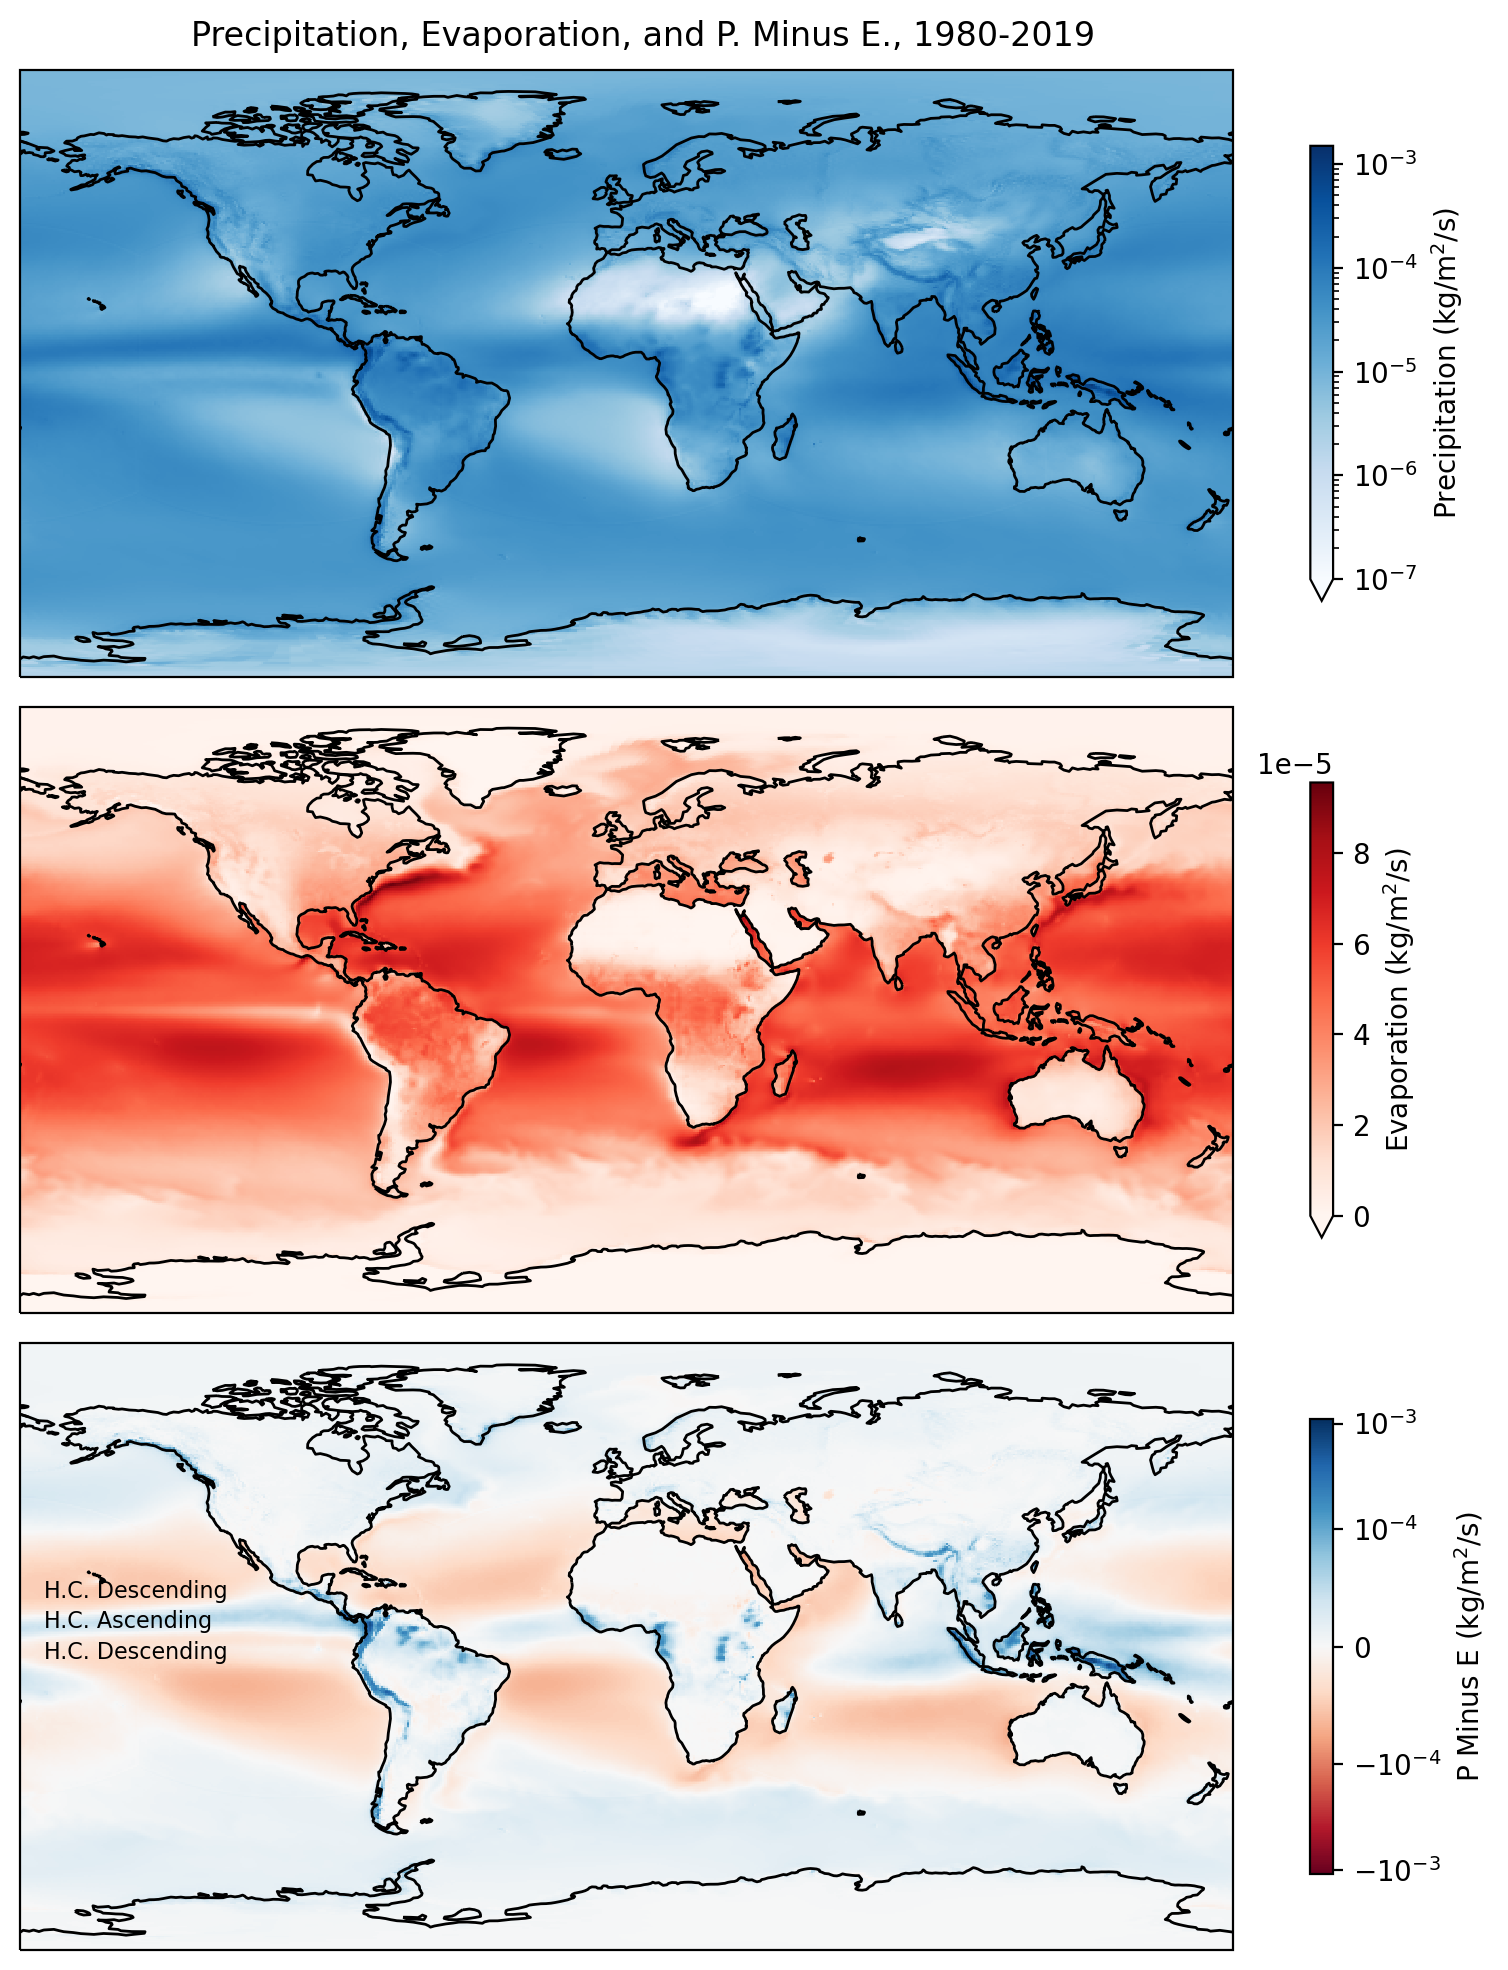

In [311]:
fig, axs = plt.subplots(figsize=(8,10),nrows=3,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()})
for ax in axs.flatten():
    ax.coastlines()
(ds_ams.PMINUSE+ds_ams.EVAP).mean('year').plot(ax=axs[0],cmap='Blues',norm=mpl.colors.LogNorm(vmin=1e-7,vmax=0.0015),cbar_kwargs={'shrink':0.75,'label':'Precipitation (kg/m$^2$/s)'})
ds_ams.EVAP.mean('year').plot(ax=axs[1],cmap='Reds',vmin=0,cbar_kwargs={'shrink':0.75,'label':'Evaporation (kg/m$^2$/s)'})
ds_ams.PMINUSE.mean('year').plot(ax=axs[2],cmap='RdBu',norm=mpl.colors.SymLogNorm(linthresh=1e-4,vmin=-1.1e-3,vmax=1.1e-3),cbar_kwargs={'shrink':0.75,'label':'P Minus E (kg/m$^2$/s)'})
axs[2].annotate('H.C. Descending',xy=(0.02,0.58),xycoords='axes fraction',fontsize=8)
axs[2].annotate('H.C. Ascending',xy=(0.02,0.53),xycoords='axes fraction',fontsize=8)
axs[2].annotate('H.C. Descending',xy=(0.02,0.48),xycoords='axes fraction',fontsize=8)
plt.suptitle('Precipitation, Evaporation, and P. Minus E., 1980-2019',x=0.42)
plt.tight_layout()

Here we have global precipitation data in the top plot, evaporation in the middle plot, and the difference between them in the bottom plot, all in the time mean from 1980 through 2019. Note that in the bottom plot, the ascending and descending branches of the Hadley cell are clearly visible (see labels). In the ascending branch, moist air rises and rains over the tropics, leading to a surplus of precipitation. In the descending branches, dry air sinks and then picks up more moisture from the ocean through evaporation, leading to a precipitation deficit, as shown in the colorbar.

Let's check out TOA net downward shortwave flux. Naturally we'd expect to see more around the equator year-round, and more in the hemisphere that's currently in summer than the one that's in winter.

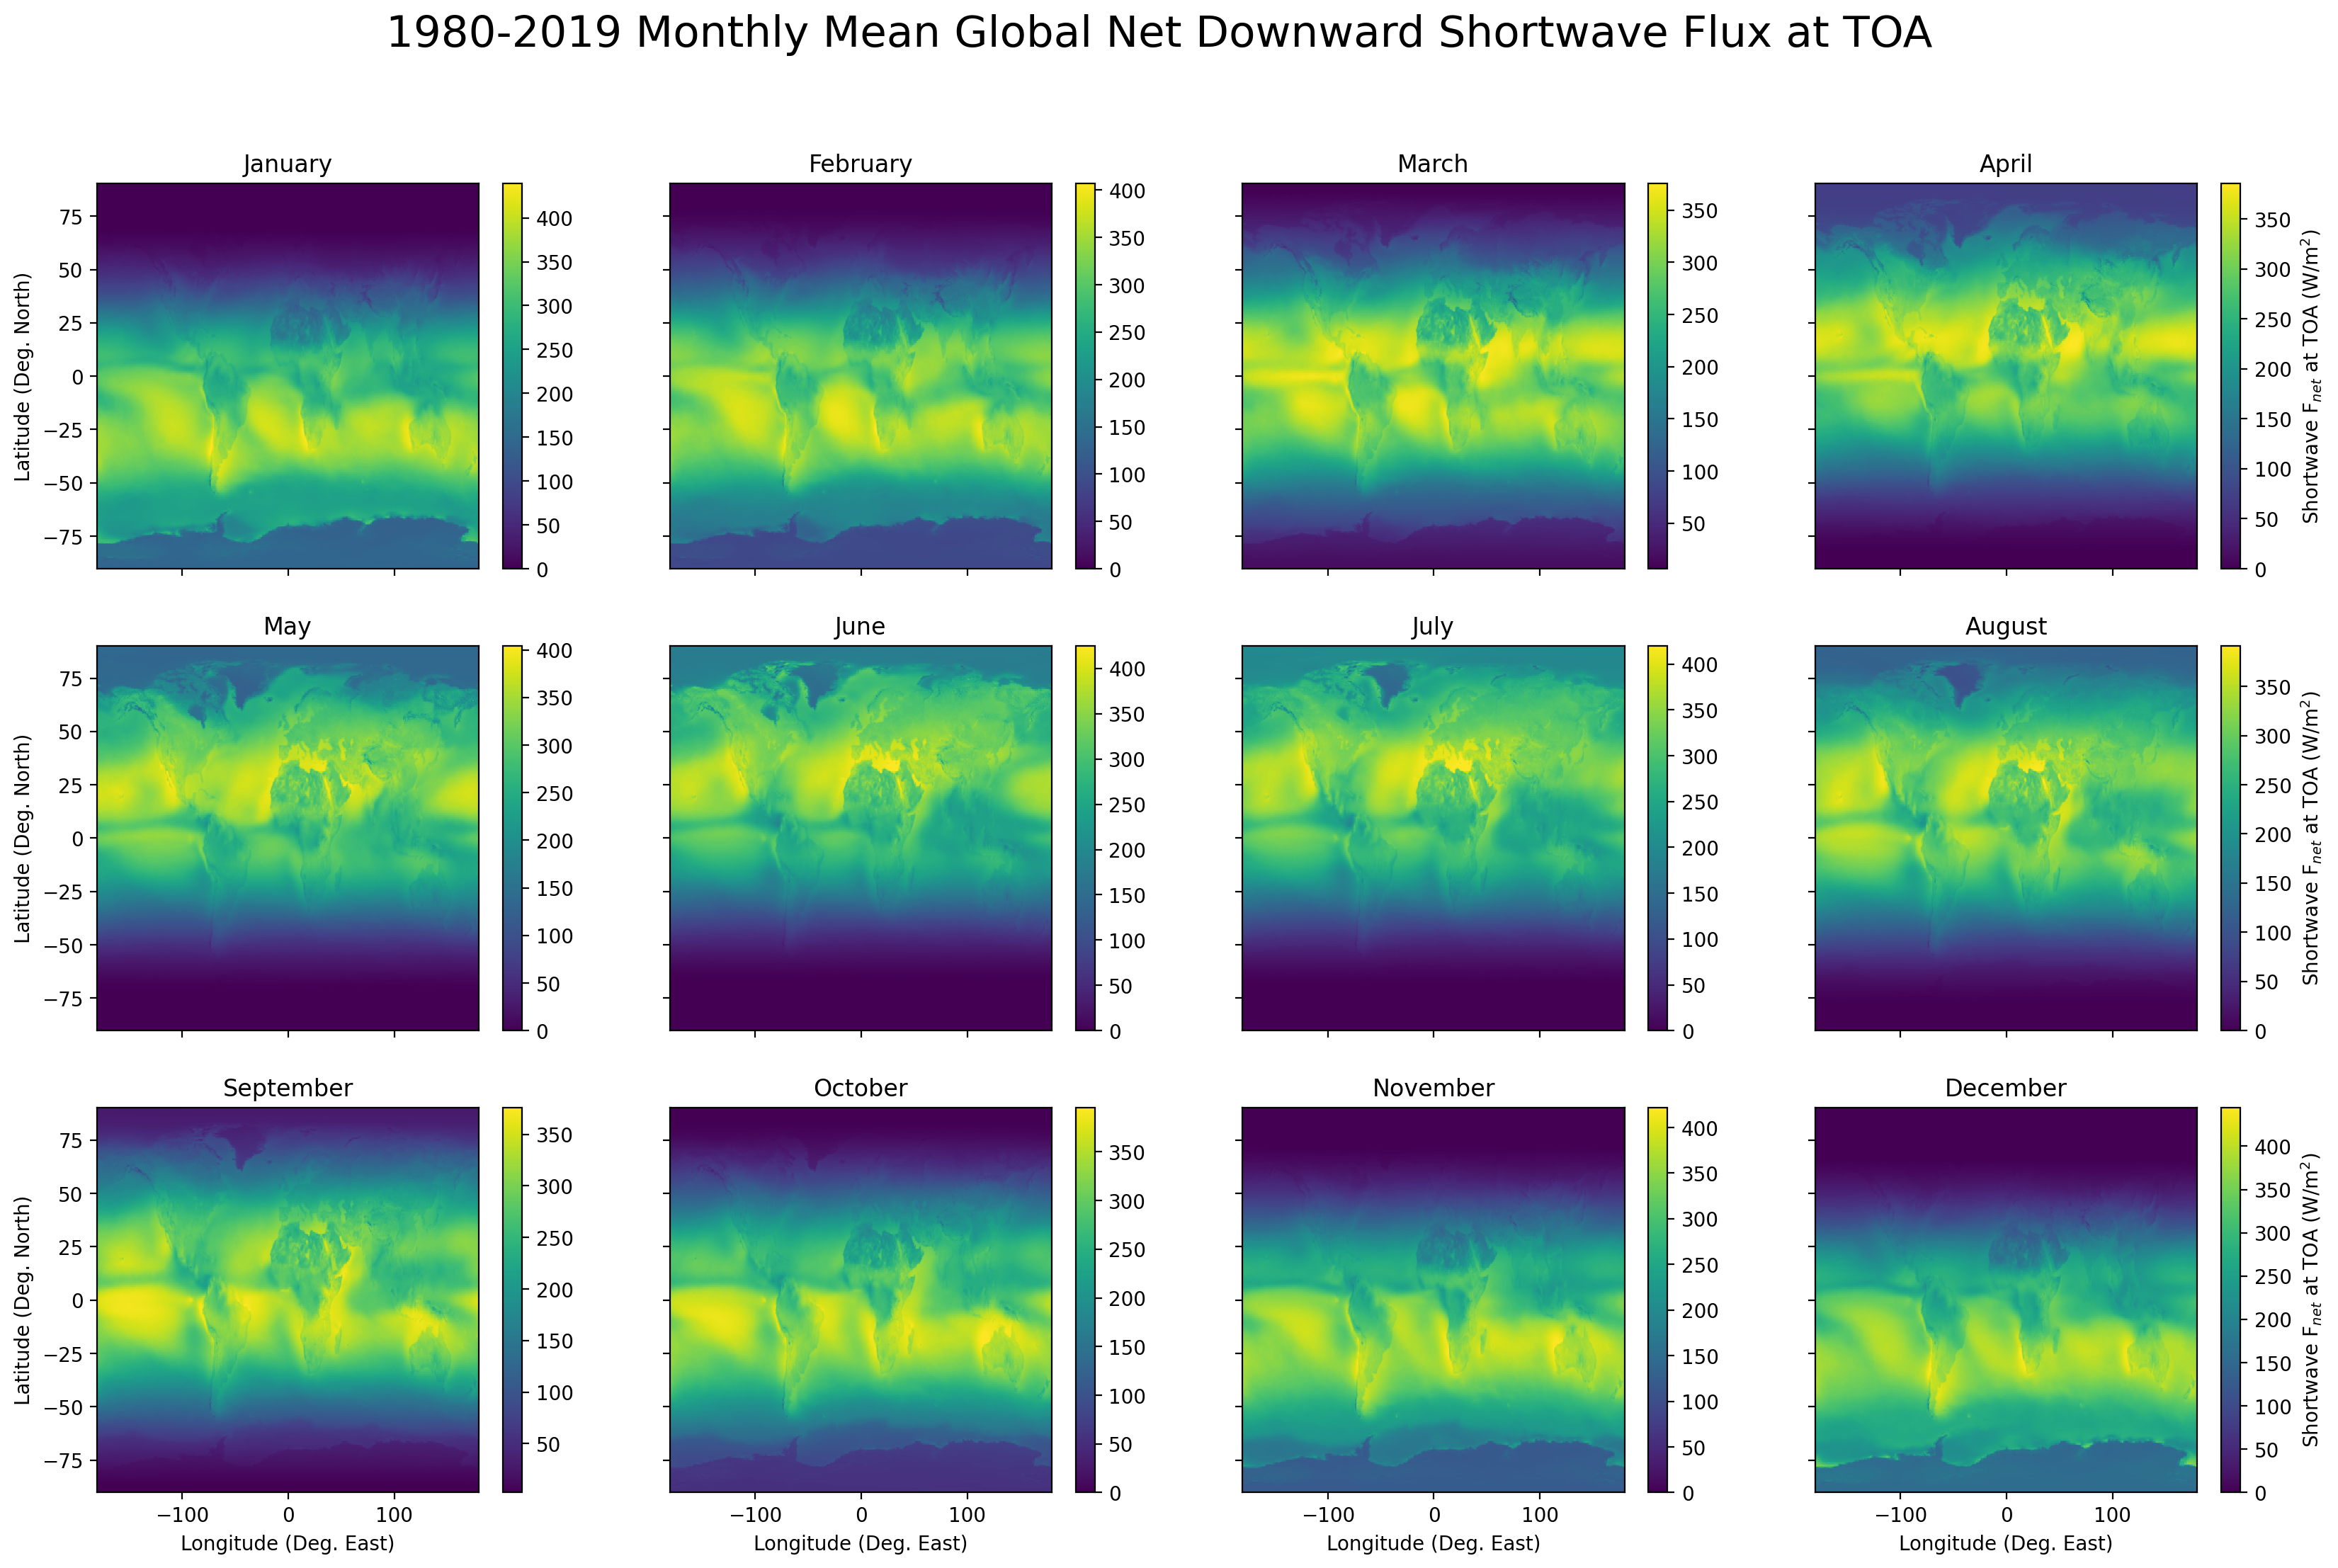

In [90]:
make_12panel('1980-2019 Monthly Mean Global Net Downward Shortwave Flux at TOA',ds_mms.SWNETTOA,r'Shortwave F$_{net}$ at TOA (W/m$^2$)')

This seasonal cycle is _exactly_ what we would expect to see, with a clear "bias" of incoming radiation towards the Northern Hemisphere in May/June/July and the Southern Hemisphere in November/December/January.

Now it's time to try to actually compute the net flux into each column. I'll break this up into three parts: 1) radiation, 2) sensible heat (i.e., conduction between the lower atmosphere and the ground), 3) latent heating (i.e., the positive contribution of evaporation). 

In [92]:
# First: radiation
# I want: - LWGNET - SWNETSRF + SWNETTOA - LWTNET
# This will give me the net flux into the column due to radiation
ds['FNETRAD'] = -ds.LWGNET - ds.SWNETSRF + ds.SWNETTOA - ds.LWTNET
ds

<xarray.Dataset>
Dimensions:   (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables:
    EVAP      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETTOA  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWGNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETSRF  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    TOTRAIN   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETRAD   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

In [94]:
# Second: sensible heat. Well, I don't have to do anything here because HFLUX is already good to go and measured
# in W/m^2. But I'll just copy that DataArray into a new one called FNETSEN so I'm consistent and clear
ds['FNETSEN'] = ds['HFLUX']
ds

<xarray.Dataset>
Dimensions:   (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables:
    EVAP      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETTOA  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWGNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETSRF  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    TOTRAIN   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETRAD   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETSEN   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

In [95]:
# Third: latent heat. 
# Recall that Lv depends on temperature - I'll use the one I found for 0.01 deg. C here:
# https://thermopedia.com/content/1150/
Lv = 2500.5e3 # latent heat of vaporization for water at 0 deg. C; J/kg
ds['FNETLAT'] = Lv * ds.EVAP # Units on this work out correctly to be W/m^2
ds

<xarray.Dataset>
Dimensions:   (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables: (12/13)
    EVAP      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    ...        ...
    LWGNET    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    SWNETSRF  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    TOTRAIN   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETRAD   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETSEN   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETLAT   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

All right - now I just need to add up the three F$_{net}$s to get the total F$_{net}$ into each column.

In [96]:
ds['FNETTOTAL'] = ds['FNETRAD'] + ds['FNETSEN'] + ds['FNETLAT']
ds

<xarray.Dataset>
Dimensions:    (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables: (12/14)
    EVAP       (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    ...         ...
    SWNETSRF   (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    TOTRAIN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETRAD    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETSEN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETLAT    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETTOTAL  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

Cool - now let me take the zonal mean of FNETTOTAL and I'll have the net flux into each latitude band. 

In [99]:
ds['FNETZONAL'] = ds.FNETTOTAL.mean('lon')
ds

<xarray.Dataset>
Dimensions:    (time: 480, lat: 361, lon: 576)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1980-01-01T00:30:00 ... 2019-12-01T00:30:00
Data variables: (12/15)
    EVAP       (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECLS     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    LWTNET     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECCU     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    PRECSN     (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    HFLUX      (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    ...         ...
    TOTRAIN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETRAD    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETSEN    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETLAT    (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETTOTAL  (time, lat, lon) float32 dask.array<chunksize=(12, 361, 576), meta=np.ndarray>
    FNETZONAL  (time, lat) float32 dask.array<chunksize=(12, 361), meta=np.ndarray>
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_int_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FQPTQ4OJ22TL
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

In [101]:
# Let's recompute the monthly and annual means of all variables now that we've added some additional
# variables (like FNETTOTAL) into the Dataset
ds_mms = get_monthly(ds)
ds_ams = get_annual_mean(ds)

Text(0.5, 1.0, '1980-2019 Annual Mean Net Flux Into the Atmospheric Column, Zonal Mean')

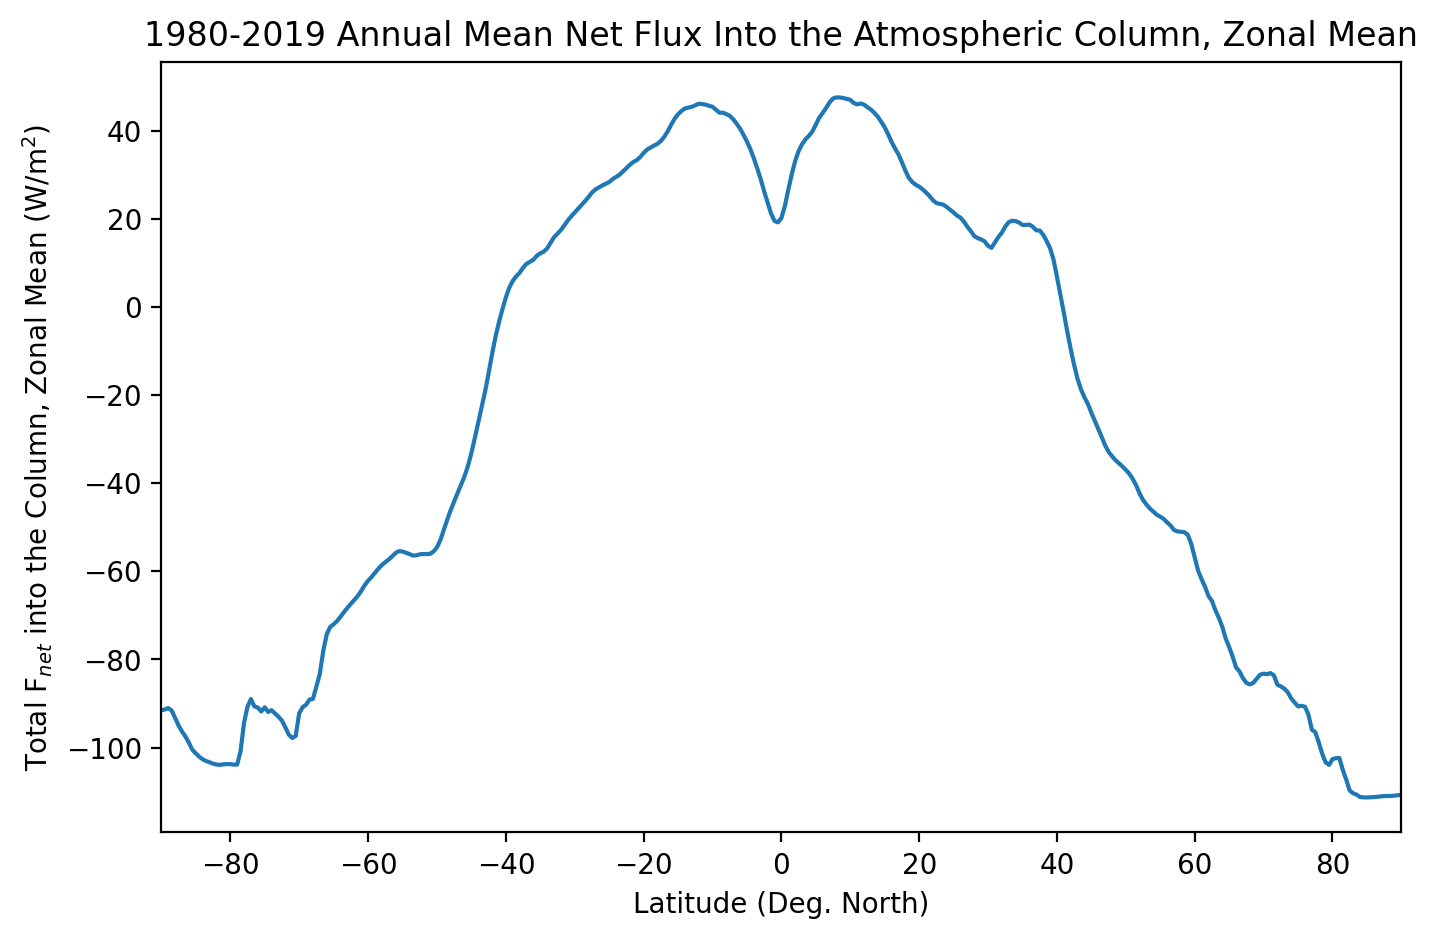

In [107]:
ds_ams.FNETZONAL.mean('year').plot(figsize=(8,5))
plt.xlabel('Latitude (Deg. North)')
plt.ylabel(r'Total F$_{net}$ into the Column, Zonal Mean (W/m$^2$)')
plt.xlim(-90,90)
plt.title('1980-2019 Annual Mean Net Flux Into the Atmospheric Column, Zonal Mean')
# TODO: Add text label for ITCZ as the central dip here

Now I have the zonal mean of the net energy flux into the column. Assuming steady state, I know this flux will flow meridionally. But how do I know whether it's going to flow north or south? 

We take advantage of a really simple mathematical reality. What I have in the plot of FNETZONAL above is the amount of energy per second that needs to be transported meridionally out of each latitude band in order to preserve steady state. Picture 2 atmospheric columns next to each other - call them column 1 and column 2, in the N. Hemi, with column 1 at a lower latitude. If column 1 has a greater F$_{net}$ than column 2, then yes, they both need to lose energy, but column 1 is going to lose more energy to column 2 than column 2 is going to lose to column 1. So it's really the _derivative_ $\frac{dF}{dy}$ that determines the flow of the "excess" energy - it will flow from higher to lower concentration. To get the actual power transported northward through each latitude (measured in W), we can do a weighted integral of $\frac{dF}{dy}$ where the weights account for the fact that latitude bands closer to the poles cover less area than those closer to the equator (this is important when converting from W/m$^2$ to W). 

OK, so now we can integrate FNETZONAL, weighted by the "area" of each latitude band, which would come from spherical geometry. We can use Eq. (A4) from [Hill, Ming, & Held (2014)](https://www.ldeo.columbia.edu/~shill/papers/hill+2015_full_with_corr.pdf) as an example; their $Q_{TOA} - Q_{sfc}$ is my $F_{net,\ tot}$, and their $a$ is the radius of the Earth:

$$F_{tot}(\phi) = \int_{-\pi/2}^{\phi}\int_{0}^{2\pi}(Q_\text{TOA}-Q_\text{sfc})a^2cos\phi\ d\lambda\ d\phi.$$

Note that what we are really about to do here is simply calculate the total area of each 0.5-degree-wide latitude band in the grid, then multiply the net flux from the figure above by this area to go from flux (W/m$^2$) to power (W).

In [116]:
r_earth = 6.378 * 10**6 # meters (m)
lat_band_areas = 2 * np.pi * r_earth**2 * np.cos(np.deg2rad(ds.lat)) * np.deg2rad(0.5)

In [119]:
lat_band_areas.sum()

<xarray.DataArray 'lat' ()>
array(5.11182688e+14)

Awesome - that means we have the band areas as the right size, because 5.11e14 sq. meters is about correct for the surface area of the entire Earth.

So now if we multiply the FNETZONAL (which is measured in W/m^2 and applies to a given latitude band) by lat_band_areas, we'll get the total power (in W) flowing out of each latitude band! 

Text(0.5, 1.0, 'Power Transported as a Function of Latitude')

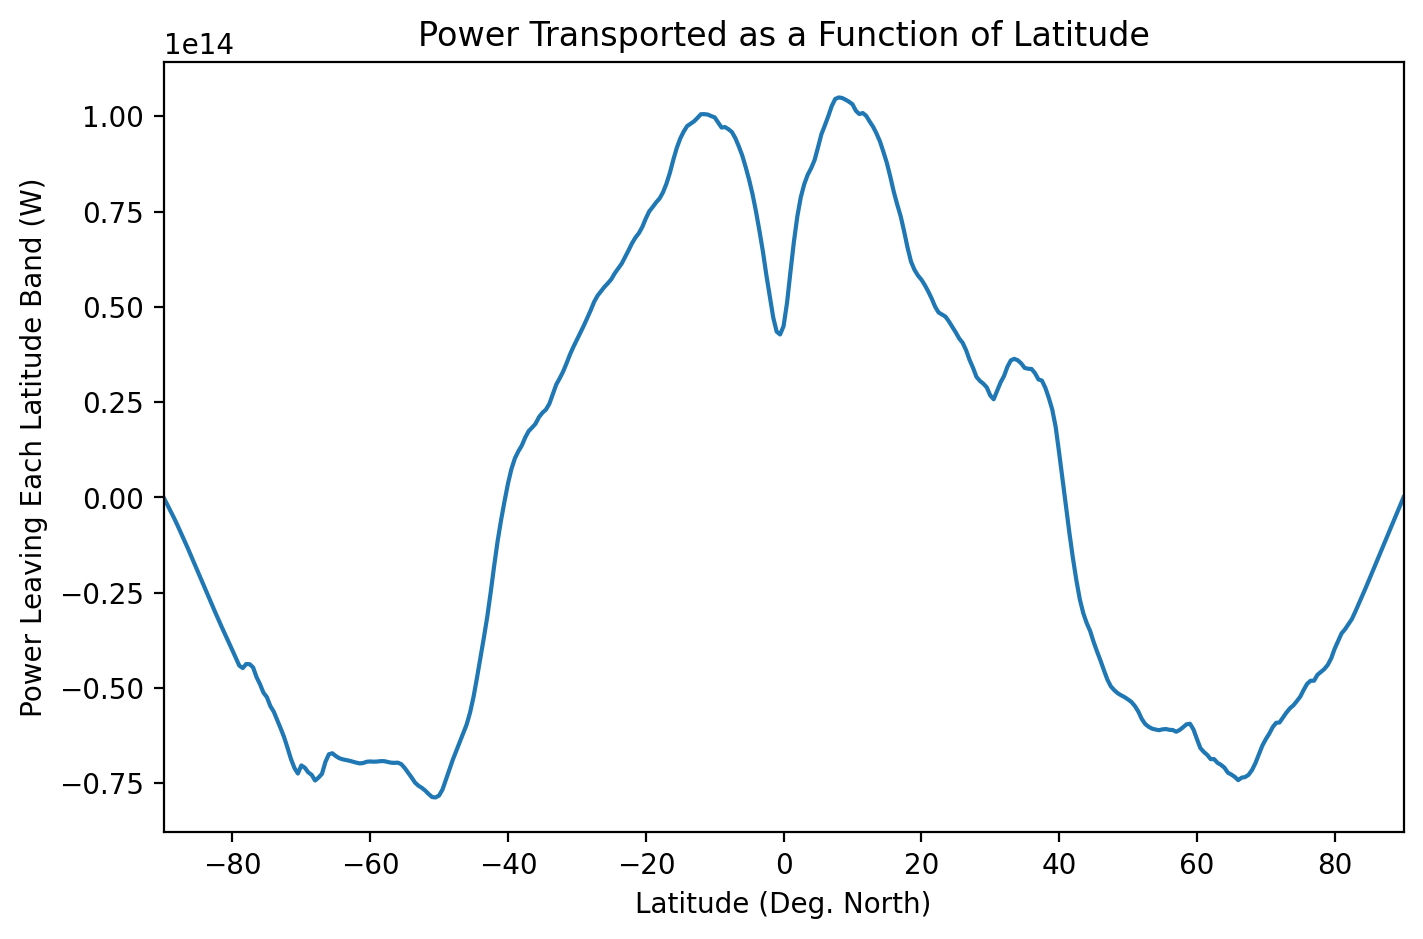

In [121]:
power_per_band = ds_ams.FNETZONAL.mean('year') * lat_band_areas
power_per_band.plot(figsize=(8,5))
plt.xlabel('Latitude (Deg. North)')
plt.ylabel('Power Leaving Each Latitude Band (W)')
plt.xlim(-90,90)
plt.title('Power Transported as a Function of Latitude')

The last step now is just to take a cumulative sum of the above in order to get the net northward energy transport in the atmosphere.

In [123]:
net_northward_transport = power_per_band.cumsum(dim='lat')

(-90.0, 90.0)

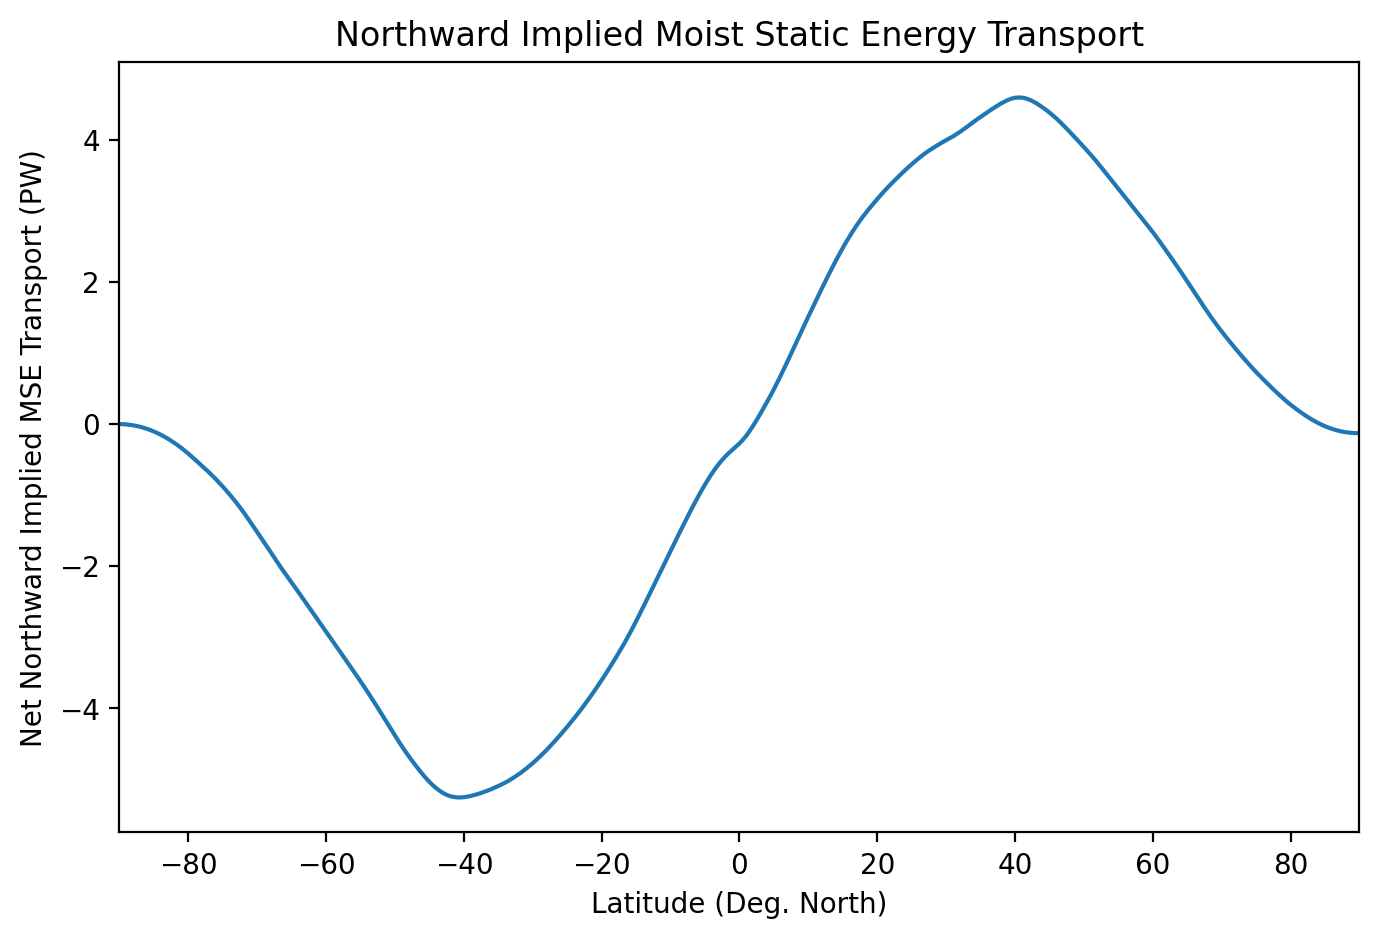

In [317]:
(net_northward_transport/1e15).plot(figsize=(8,5))
plt.xlabel('Latitude (Deg. North)')
plt.ylabel('Net Northward Implied MSE Transport (PW)')
plt.title('Northward Implied Moist Static Energy Transport')
plt.xlim(-90,90)

This looks good - the magnitude of energy transported meshes well with previous literature (including the plot at the top of the notebook), and it's roughly zero at the poles and the equator. It should be exactly zero both poles, but there is always some error in reanalysis datasets. In a more thorough analysis, I could prescribe that the two poles must have zero transport.

The next step for this project is to compute the _actual_ (not implied) MSE transport, and to break this down into components from the mean meridional circulation (MMC; i.e., Hadley cell) and from stationary and transient eddies. Once I do that, I'll be able to see whether there's an offset in the energy-flux equators of the total and MMC components like my advisor unexpectedly found in the ERA5 reanalysis. If that offset appears in MERRA-2 as well, it's likely not an artifact of the reanalysis and could mean that eddies play a bigger role in affecting the total transport of energy than we previously understood.

## References

1. Donohoe, A., Armour, K. C., Roe, G. H., Battisti, D. S., & Hahn, L., 2020. "The Partitioning of Meridional Heat Transport from the Last Glacial Maximum to CO$_2$ Quadrupling in Coupled Climate Models." _J. Clim._, 33, 4141-4165.
2. Hill, S. A., Ming, Y., & Held, I. M., 2015. "Mechanisms of Forced Tropical Meridional Energy Flux Change." _J. Clim._, 28, 1725-1742. 
3. Kiranmayi, L., & Maloney, E. D., 2011. "Intraseasonal Moist Static Energy Budget in Reanalysis Data." _J. Geophys. Res._, 116, D21117.
4. Vellinga, M., & Wu, P., 2008. "Relations between Northward Ocean and Atmosphere Energy Transports in a Coupled Climate Model." _J. Clim._, 21, 561-575.